In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report,roc_auc_score, roc_curve, PrecisionRecallDisplay,precision_recall_curve, auc)
import joblib
# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
df = pd.read_csv(r"C:\Users\veera\Downloads\PRANAV B\docs\projects\Transactional Fraud Detection Analysis\data\clean_creditcard.csv")  # adjust path if needed
df.shape, df['Class'].value_counts()

((284807, 31),
 Class
 0    284315
 1       492
 Name: count, dtype: int64)

In [3]:
# Cell 3 — feature engineering
df = df.copy()
# Hour feature (0-23)
df['Hour'] = ((df['Time'] / 3600) % 24).astype(int)
# Log transform amount
df['Amount_log'] = np.log1p(df['Amount'])
# Features list (V1..V28 exist in the dataset)
pca_cols = [c for c in df.columns if c.startswith('V')]
feature_cols = pca_cols + ['Amount_log', 'Hour']
target_col = 'Class'

# Quick check
df[feature_cols + [target_col]].head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount_log,Hour,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539,0,0


In [4]:
# Cell 4 — train/test split (stratified)
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))


Train shape: (227845, 30) Test shape: (56962, 30)
Train class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


In [6]:
# Cell 5 — Baseline pipeline: scaling + logistic regression (class_weight)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV ROC-AUC:", gs.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 0.01, 'clf__class_weight': None}
Best CV ROC-AUC: 0.9826883575841971


              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9995     56864
           1     0.8169    0.5918    0.6864        98

    accuracy                         0.9991     56962
   macro avg     0.9081    0.7958    0.8430     56962
weighted avg     0.9990    0.9991    0.9990     56962

Test ROC-AUC: 0.9756592528682828


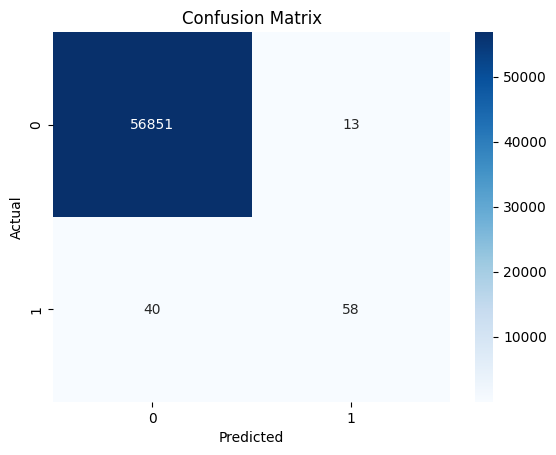

In [7]:
# Cell 6 — Evaluate on test set (pipeline with class_weight)
best_pipe = gs.best_estimator_
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC:", roc_auc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


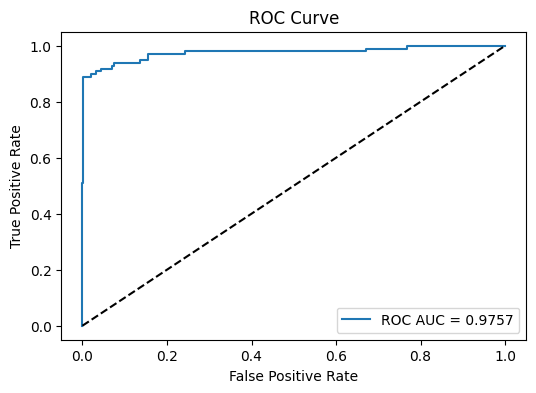

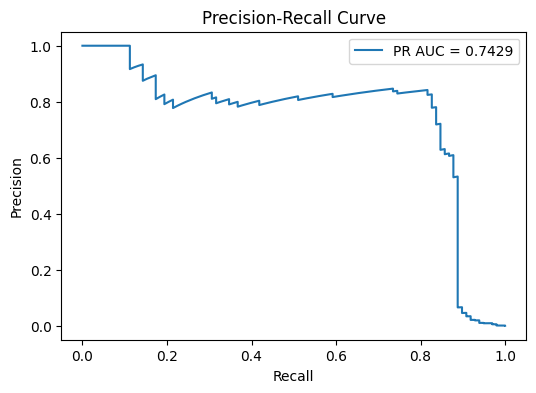

In [8]:
# Cell 7 — ROC & PR curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [9]:
# Cell 8 — Try SMOTE pipeline (only on training set via imblearn pipeline)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Cell 8 — Try SMOTE pipeline (only on training set via imblearn pipeline)
smote_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])

param_grid_smote = {
    'clf__C': [0.01, 0.1, 1],
    'clf__class_weight': [None, 'balanced']
}

gs_smote = GridSearchCV(
    smote_pipe,
    param_grid_smote,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
gs_smote.fit(X_train, y_train)

print("Best SMOTE params:", gs_smote.best_params_)
print("Best SMOTE CV ROC-AUC:", gs_smote.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best SMOTE params: {'clf__C': 0.01, 'clf__class_weight': None}
Best SMOTE CV ROC-AUC: 0.9801339848746947


In [10]:
# Cell 9 — Evaluate SMOTE model
best_smote = gs_smote.best_estimator_
y_pred_smote = best_smote.predict(X_test)
y_proba_smote = best_smote.predict_proba(X_test)[:,1]

print("SMOTE Model classification report:")
print(classification_report(y_test, y_pred_smote, digits=4))
print("SMOTE Test ROC-AUC:", roc_auc_score(y_test, y_proba_smote))


SMOTE Model classification report:
              precision    recall  f1-score   support

           0     0.9999    0.9733    0.9864     56864
           1     0.0560    0.9184    0.1056        98

    accuracy                         0.9732     56962
   macro avg     0.5279    0.9459    0.5460     56962
weighted avg     0.9982    0.9732    0.9849     56962

SMOTE Test ROC-AUC: 0.9718148672665465


In [11]:
# Cell 10 — Choose final model (compare ROC-AUC or preferred metric)
# For demo, pick whichever has higher test ROC-AUC
roc_base = roc_auc_score(y_test, best_pipe.predict_proba(X_test)[:,1])
roc_sm = roc_auc_score(y_test, best_smote.predict_proba(X_test)[:,1])
print("Base ROC:", roc_base, "SMOTE ROC:", roc_sm)

# Pick final pipeline
final_model = best_smote if roc_sm >= roc_base else best_pipe
print("Selected final model:", final_model)


Base ROC: 0.9756592528682828 SMOTE ROC: 0.9718148672665465
Selected final model: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42,
                                    solver='liblinear'))])


In [12]:
# Cell 11 — Save final pipeline
joblib.dump(final_model,"C:/Users/veera/Downloads/PRANAV B/docs/projects/Transactional Fraud Detection Analysis/models/fraud_pipeline_v1.joblib")

print("Saved pipeline to ../models/fraud_pipeline_v1.joblib")


Saved pipeline to ../models/fraud_pipeline_v1.joblib


In [16]:
!jupyter nbconvert --to html "week3_modeling.ipynb" --output-dir="reports"


[NbConvertApp] Converting notebook week3_modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 384282 bytes to reports\week3_modeling.html


In [17]:
!jupyter nbconvert --to html "week3_modeling.ipynb" --output-dir="reports"

[NbConvertApp] Converting notebook week3_modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 384282 bytes to reports\week3_modeling.html
